# Data Science Challenge

<br>

Understanding tasker cancellation

__Author:__ Qian Chen

__Date:__ Sat, 14 Mar 2020

__Contact:__ chen.qian.dan@gmail.com

# Background
<br>
The website is a two sided marketplace where posters can post tasks that they need done and taskers can bid on tasks and earn money. 
<br>
<br>
Taskers go through a flow of:

1. Searching for tasks on the platform.
2. Making an offer on tasks by quoting a price and leaving a message. 
3. Getting assigned to a task by a poster. 
4. Doing the work. 
5. Getting paid through the website. 

<br>
Sometimes things don't go as expected for the poster. A tasker not completing a task they've been assigned is an example of things not going as expected. This can happen for a number of reasons including:

1. Tasker not showing up. 
2. Tasker double booking and having to cancel on a customer. 
3. Tasker completing the job, but asking the poster to pay in cash instead of through the platform. 

<br>
The company would like to understand who is going to be a productive tasker on the platform and who is going to cancel tasks. The company would like to summarise this understanding with a predictive measure of a tasker's likelihood to cancel. 

<br>
<br>

* Offer / poster: employer
* Tasker: employee

# Challenge
<br>
Your challenge is to explore some of our data around task cancelation and 

1. Build a model predicting how likely a tasker is to cancel a task. 
2. Demonstrate the validity of this model. 
3. Use this model to give every tasker a score indicating how likely they are to cancel in the future. 

We would also like to know your answers to the following questions:

1. Why did you choose the model that you chose vs other models?
2. What different ideas did you try to build your model?
3. How would you communicate how this model works and its effectiveness to someone who is non-technical?
4. What are the limitations of this model?
5. What extra data points could be tested to improve the results?

# Data

We've supplied the following datasets:

1. Taskers
2. Reviews
3. Offers
4. Comments 
5. Tasks

See diagram below:

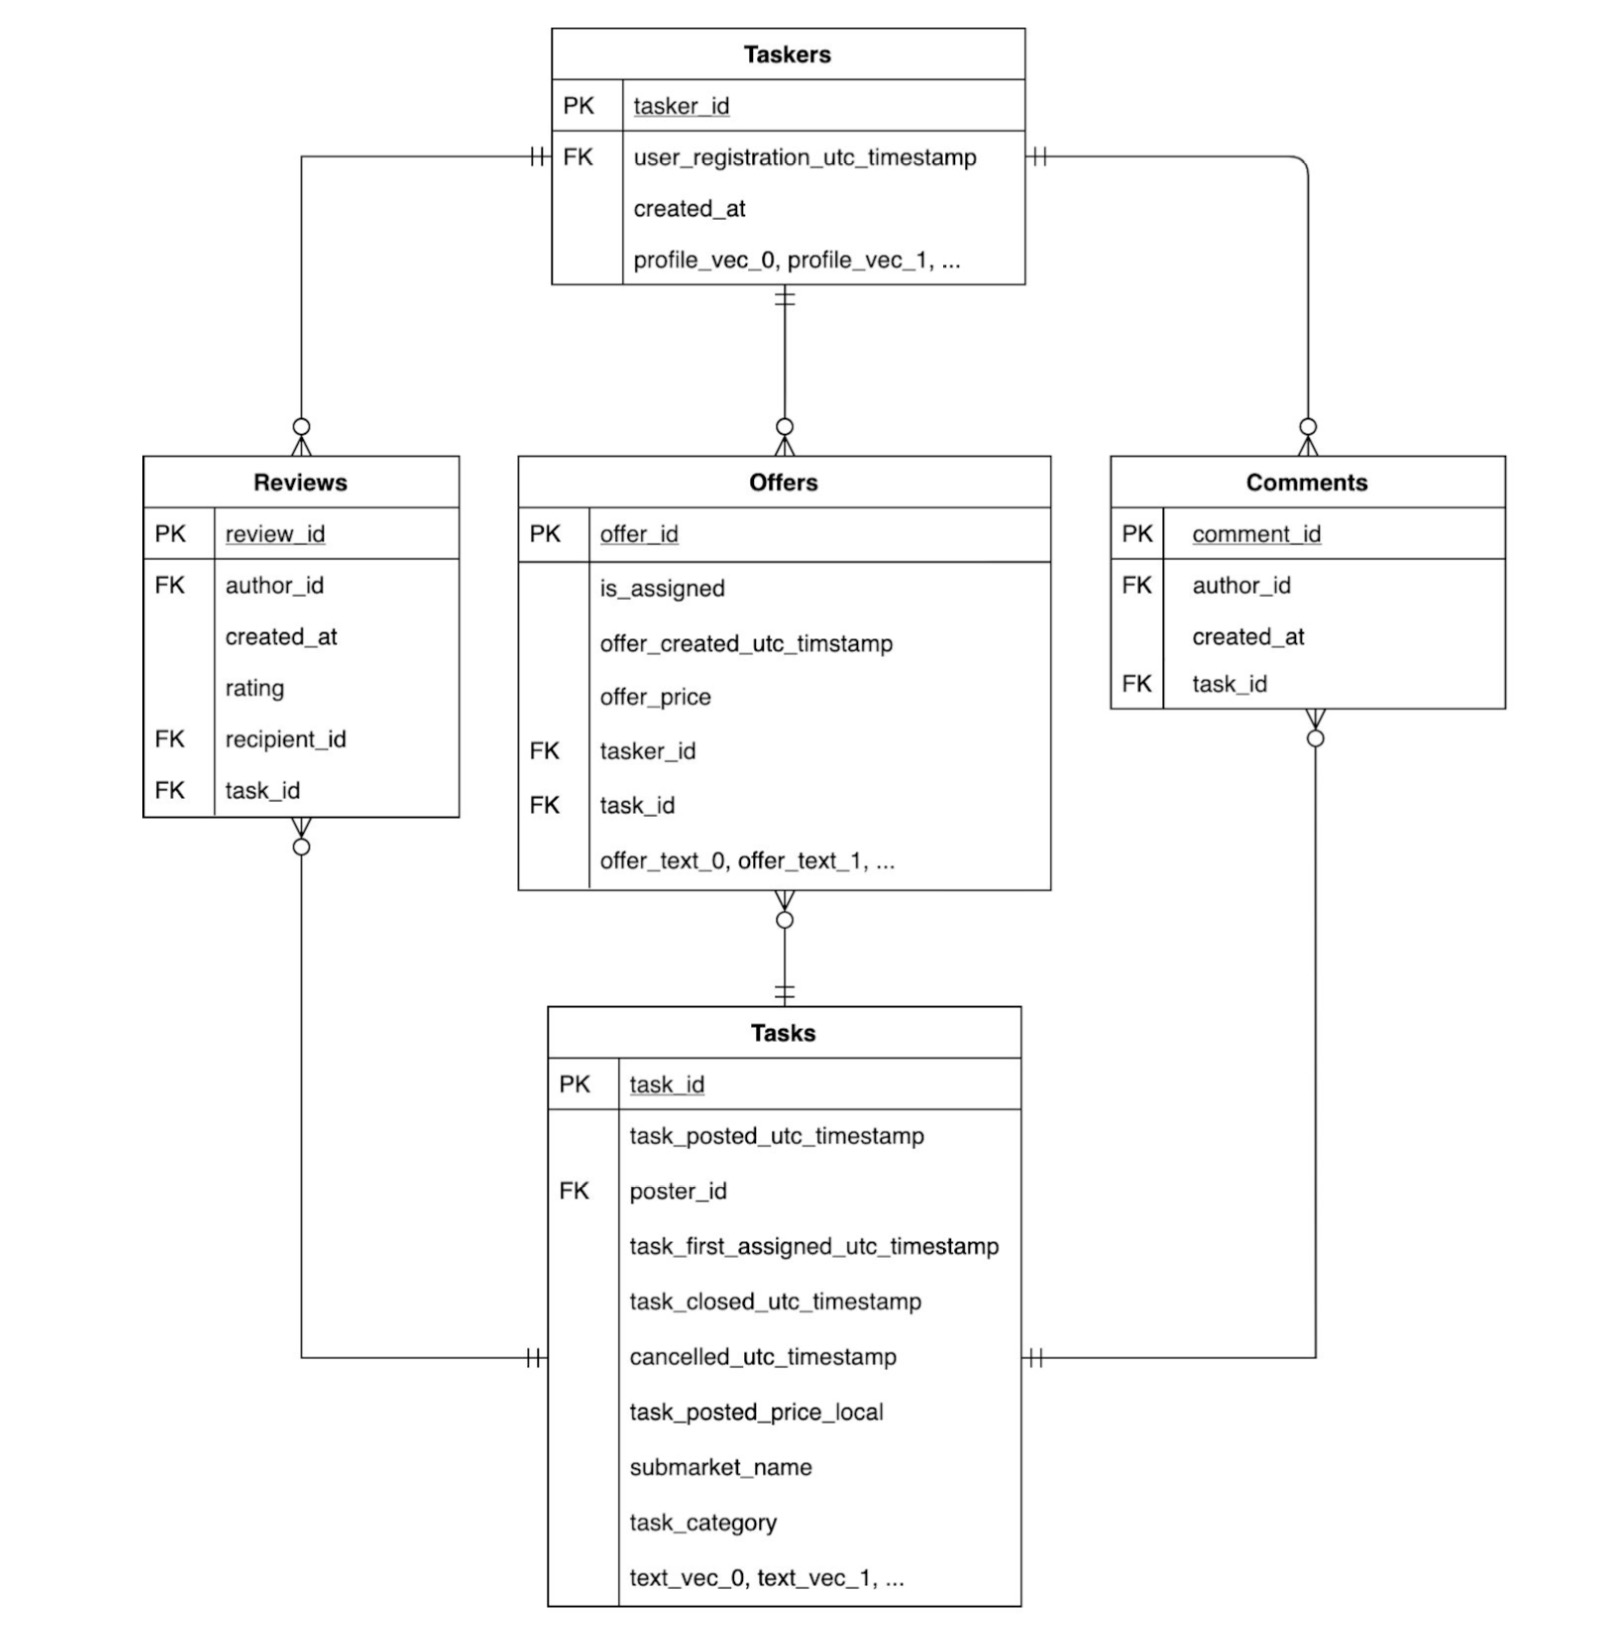

In [1]:
from IPython.display import Image
Image('../input/datasets_structure.jpg')

<hr>

# 1 Import libraries

In [2]:
# !pip install --upgrade pip
# !conda install -c conda-forge imbalanced-learn
# !conda install -c conda-forge lightgbm

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('whitegrid')

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

import gc # for free up memory

%matplotlib inline

# 2 Import data

## 2.1 Dataset: Taskers

In [4]:
# low_memory=False to avoid mixing type inference.
start_df_taskers = pd.read_csv('../input/tasker.csv', low_memory=False)

In [5]:
# working on a copy of the dataframe so that we don't need to re-read the entire dataset 
# again in order to save memory.
# deep = True : copy by value
# deep = False : copy by reference
df_taskers = start_df_taskers.copy(deep = True)

## 2.2 Dataset: Reviews

In [6]:
# low_memory=False to avoid mixing type inference.
start_df_reviews = pd.read_csv('../input/reviews.csv', low_memory=False)

In [7]:
# working on a copy of the dataframe so that we don't need to re-read the entire dataset 
# again in order to save memory.
# deep = True : copy by value
# deep = False : copy by reference
df_reviews = start_df_reviews.copy(deep = True)

## 2.3 Dataset: Offers

In [8]:
# low_memory=False to avoid mixing type inference.
start_df_offers = pd.read_csv('../input/offers.csv', low_memory=False)

In [9]:
# working on a copy of the dataframe so that we don't need to re-read the entire dataset 
# again in order to save memory.
# deep = True : copy by value
# deep = False : copy by reference
df_offers = start_df_offers.copy(deep = True)

## 2.4 Dataset: Comments

In [10]:
# low_memory=False to avoid mixing type inference.
start_df_comments = pd.read_csv('../input/comments.csv', low_memory=False)

In [11]:
# working on a copy of the dataframe so that we don't need to re-read the entire dataset 
# again in order to save memory.
# deep = True : copy by value
# deep = False : copy by reference
df_comments = start_df_comments.copy(deep = True)

## 2.5 Dataset: Tasks

In [12]:
# low_memory=False to avoid mixing type inference.
start_df_tasks = pd.read_csv('../input/tasks.csv', low_memory=False)

In [13]:
# working on a copy of the dataframe so that we don't need to re-read the entire dataset 
# again in order to save memory.
# deep = True : copy by value
# deep = False : copy by reference
df_tasks = start_df_tasks.copy(deep = True)

# 3 Understand the data
<br>
<br>
In this part, we understand the data set generally by:

1. Have a first look of the dataset. 
2. Check missing value. 
3. Have a look of the column names. 
4. Drop obvious unhelpful columns. 
5. Simplify the timestamp by exacting only the year and month. 
6. Check if the promary key is unique (we noticed that taskers primary key is not unique.)

In [14]:
def find_null_values(df: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
    """
    find # of missing values and its percentage in the given dataframe. 
    """
    mis_val_series = df.isnull().sum()
    mis_val_percent = 100 * mis_val_series / len(df)
    mis_val_table = pd.concat([mis_val_series, mis_val_percent], axis=1)
    
    # rename table column names
    mis_val_table_columns = mis_val_table.rename(columns = {0: '# of missing values', 
                                                            1: '% of total values'})
    
    # sort for % of total values
    mis_val_table_columns = \
    mis_val_table_columns[
                          mis_val_table_columns.iloc[:, 1] != 0
                         ].sort_values('% of total values', ascending=False) \
                          .round(1)
    
    print('Dataframe has {} columns.'.format(df.shape[1]))
    print('There are {} columns have missing values.'.format(mis_val_table_columns.shape[0]))
    
    return mis_val_table_columns

In [15]:
def find_values(df: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
    """
    find # of values and its percentage in the given dataframe. 
    """
    val_series = len(df) - df.isnull().sum()
    val_percent = 100 * val_series / len(df)
    val_table = pd.concat([val_series, val_percent], axis=1)
    
    # rename table column names
    val_table_columns = val_table.rename(columns = {0: '# of values', 
                                                    1: '% of total values'})
    
    # sort for % of total values
    val_table_columns = \
    val_table_columns[
                       val_table_columns.iloc[:, 1] != 0
                     ].sort_values('% of total values', ascending=True) \
                     .round(1)
    
    print('Dataframe has {} columns.'.format(df.shape[1]))
 
    return val_table_columns

## 3.1 Taskers

In [16]:
df_taskers.head(5)

,Unnamed: 0,tasker_id,user_registration_utc_timestamp,profile_vec_0,profile_vec_1,profile_vec_2,profile_vec_3,profile_vec_4,profile_vec_5,profile_vec_6,profile_vec_7,profile_vec_8,profile_vec_9,created_at
0,0,f2de865779,2018-05-10 14:56:02.109567+00:00,-1.190706,-0.143689,-0.064413,-0.213398,1.566940,1.335470,4.197479,-0.338899,0.424799,-5.573584,2019-11-20 10:45:16.746421
1,1,bac094ddf6,2018-11-29 06:56:21.046109+00:00,0.375901,0.430404,-0.846052,-0.430270,-1.122172,-0.082642,-0.779161,3.047018,-0.338897,2.361305,2019-12-07 01:22:16.046655
2,2,3c990864bc,2017-11-12 02:42:40.529365+00:00,0.557829,0.656698,-1.648849,0.912972,1.306814,0.989758,1.715636,0.184456,-0.449483,-4.071984,2019-12-19 14:24:22.489389
3,3,3c990864bc,2017-11-12 02:42:40.529365+00:00,-1.309713,-3.675500,0.718797,-0.303333,-3.777436,-0.837588,0.156469,0.259425,0.791848,8.130877,2019-12-29 07:43:37.859351
4,4,3c990864bc,2017-11-12 02:42:40.529365+00:00,1.263908,0.593024,0.380853,0.618160,-2.139417,0.321908,-0.081639,4.841459,-2.741829,-2.902581,2019-12-23 16:02:46.145834


In [17]:
# check missing value.
miss_values_taskers = find_null_values(df_taskers)
miss_values_taskers.head(10)

Dataframe has 14 columns.
There are 0 columns have missing values.


,# of missing values,% of total values


In [18]:
# print out the column names
df_taskers.columns

Index(['Unnamed: 0', 'tasker_id', 'user_registration_utc_timestamp',
       'profile_vec_0', 'profile_vec_1', 'profile_vec_2', 'profile_vec_3',
       'profile_vec_4', 'profile_vec_5', 'profile_vec_6', 'profile_vec_7',
       'profile_vec_8', 'profile_vec_9', 'created_at'],
      dtype='object')

In [19]:
# check primary key
s1 = df_taskers.shape
s2 = len(df_taskers['tasker_id'].drop_duplicates())

print('df_taskers.shape = {}'.format(s1))
print("len(df_taskers['tasker_id'] = {}".format(s2))

df_taskers.shape = (1896267, 14)
len(df_taskers['tasker_id'] = 68969


> We can see df_tasker.shape = (1896267, 14) and len(df_tasker['tasker_id'].drop_duplicates()) = 68969, so the primary key 'tasker_id' __is not unique__. 
>
>Since I don't have enough information for why this would happen, let us drop columns 'Unnamed: 0' and simplify timestamp. 
> for duplicate tasker_id, sum the profile_vec up and use mean value to replace them. 

In [20]:
# drop columns. 
columns = ['Unnamed: 0'] 
df_taskers.drop(columns, axis=1, inplace=True)

In [21]:
# simplify the timestamp by extracting only the year and month.
colum_name = 'user_registration_utc_timestamp'
df_taskers[colum_name] = [x[0:7] for x in df_taskers[colum_name]]

colum_name = 'created_at'
df_taskers[colum_name] = [x[0:7] for x in df_taskers[colum_name]]

In [22]:
# for duplicated taster_id, use mean to replace profile_vec_i
df_taskers = df_taskers.groupby(['tasker_id']).mean()
df_taskers.reset_index(inplace=True)

In [23]:
# check primary key again. 
s1 = df_taskers.shape
s2 = len(df_taskers['tasker_id'].drop_duplicates())

print('df_taskers.shape = {}'.format(s1))
print("len(df_taskers['tasker_id'] = {}".format(s2))

df_taskers.shape = (68969, 11)
len(df_taskers['tasker_id'] = 68969


> Now 'tasker_id' is unique.

In [24]:
df_taskers.head(5)

,tasker_id,profile_vec_0,profile_vec_1,profile_vec_2,profile_vec_3,profile_vec_4,profile_vec_5,profile_vec_6,profile_vec_7,profile_vec_8,profile_vec_9
0,00012eb349,-0.312101,-0.783148,0.337971,-0.143495,0.780149,0.581566,0.879678,0.309804,-0.261848,-0.008343
1,0003a8e176,0.229196,0.009701,0.202017,-0.115509,0.375068,0.312995,-0.029202,-0.289909,0.171965,-0.609913
2,0004f10132,-0.310983,1.147941,-4.151912,0.000708,-2.422936,-1.228314,1.291720,-0.084535,-2.194157,1.029179
3,0005c60db0,-0.211088,0.036709,0.074639,0.132703,-0.055203,-0.300715,-0.835180,-0.054928,0.420705,0.941294
4,0006937518,-1.582722,1.082717,-0.146968,-0.860466,-1.216439,-1.757879,0.127624,-0.660060,0.018899,-1.480685


In [25]:
# print out the columns names
df_taskers.columns

Index(['tasker_id', 'profile_vec_0', 'profile_vec_1', 'profile_vec_2',
       'profile_vec_3', 'profile_vec_4', 'profile_vec_5', 'profile_vec_6',
       'profile_vec_7', 'profile_vec_8', 'profile_vec_9'],
      dtype='object')

## 3.2 Reviews

In [26]:
df_reviews.head(5)

,Unnamed: 0,author_id,created_at,rating,recipient_id,review_id,task_id
0,0,ddd2098814,2019-09-09 01:23:44.892277+00:00,5,982a21b617,2486800,openmarket:5233781
1,1,d0e0791444,2019-07-31 08:00:27+00:00,5,0e431ebb1b,2382231,openmarket:5047650
2,2,0e431ebb1b,2019-08-01 07:38:40+00:00,5,d0e0791444,2384764,openmarket:5047650
3,3,81e915399d,2019-10-21 03:40:07.348176+00:00,2,1068c291cd,2602668,openmarket:5273603
4,4,1068c291cd,2019-10-15 09:49:36.504345+00:00,5,81e915399d,2587061,openmarket:5273603


In [27]:
# check missing value.
miss_values_reviews = find_null_values(df_reviews)
miss_values_reviews.head(10)

Dataframe has 7 columns.
There are 0 columns have missing values.


,# of missing values,% of total values


In [28]:
# print out the column names
df_reviews.columns

Index(['Unnamed: 0', 'author_id', 'created_at', 'rating', 'recipient_id',
       'review_id', 'task_id'],
      dtype='object')

In [29]:
# drop columns. 
columns = ['Unnamed: 0'] 
df_reviews.drop(columns, axis=1, inplace=True)

In [30]:
# simplify the timestamp
df_reviews['created_at'] = [x[0:7] for x in df_reviews['created_at']]

In [31]:
# check primary key
s1 = df_reviews.shape
s2 = len(df_reviews['review_id'].drop_duplicates())

print('df_reviews.shape = {}'.format(s1))
print("len(df_reviews['review_id'] = {}".format(s2))

df_reviews.shape = (311526, 6)
len(df_reviews['review_id'] = 311526


> 'review_id' is unique.

In [32]:
df_reviews.head(5)

,author_id,created_at,rating,recipient_id,review_id,task_id
0,ddd2098814,2019-09,5,982a21b617,2486800,openmarket:5233781
1,d0e0791444,2019-07,5,0e431ebb1b,2382231,openmarket:5047650
2,0e431ebb1b,2019-08,5,d0e0791444,2384764,openmarket:5047650
3,81e915399d,2019-10,2,1068c291cd,2602668,openmarket:5273603
4,1068c291cd,2019-10,5,81e915399d,2587061,openmarket:5273603


In [33]:
df_reviews.columns

Index(['author_id', 'created_at', 'rating', 'recipient_id', 'review_id',
       'task_id'],
      dtype='object')

## 2.3 Offers

In [34]:
df_offers.head(5)

,Unnamed: 0,is_assigned,offer_created_utc_timestamp,offer_id,offer_price,tasker_id,task_id,offer_text_0,offer_text_1,offer_text_2,...,offer_text_10,offer_text_11,offer_text_12,offer_text_13,offer_text_14,offer_text_15,offer_text_16,offer_text_17,offer_text_18,offer_text_19
0,0,False,2019-05-13 11:09:48.654000+00:00,12505658,40.38,9274fd8f97,openmarket:4695708,-9.190240,-6.802488,7.407354,...,-5.944327,5.944327,-6.056989,-9.19024,-7.447743,-9.190240,9.190240,-4.595120,-5.388058,-9.190240
1,1,False,2019-07-28 01:46:32+00:00,13820546,27.08,7ed6036343,openmarket:5041854,-9.190240,9.190240,7.270450,...,6.966459,-9.190240,4.047269,-9.19024,9.190240,7.037461,9.190240,-9.190240,6.802488,6.474153
2,2,False,2019-05-11 13:57:20.382000+00:00,12472310,153.51,1eaf530311,openmarket:4686699,9.190240,9.190240,-6.194529,...,-6.538344,-5.273306,3.245913,9.19024,-8.042354,-7.236244,7.133284,-0.000000,9.190240,-1.685946
3,3,False,2019-05-28 04:55:21.603000+00:00,12776392,50.64,82b438245c,openmarket:4755641,6.247637,9.190240,5.755125,...,6.404886,-0.000000,7.364526,-5.14297,-0.000000,-6.802488,-9.190240,-4.992259,-6.888576,5.332396
4,4,False,2019-08-26 07:07:25.206689+00:00,14318361,100.28,0c5de8dc6e,openmarket:5186867,-6.275841,-4.595120,0.000000,...,5.273306,7.162765,-4.595120,-9.19024,5.351314,5.490505,6.492980,4.197981,-9.190240,-9.190240


In [35]:
# check missing value.
miss_values_offers = find_null_values(df_offers)
miss_values_offers.head(10)

Dataframe has 27 columns.
There are 0 columns have missing values.


,# of missing values,% of total values


In [36]:
# print out the column names
df_offers.columns

Index(['Unnamed: 0', 'is_assigned', 'offer_created_utc_timestamp', 'offer_id',
       'offer_price', 'tasker_id', 'task_id', 'offer_text_0', 'offer_text_1',
       'offer_text_2', 'offer_text_3', 'offer_text_4', 'offer_text_5',
       'offer_text_6', 'offer_text_7', 'offer_text_8', 'offer_text_9',
       'offer_text_10', 'offer_text_11', 'offer_text_12', 'offer_text_13',
       'offer_text_14', 'offer_text_15', 'offer_text_16', 'offer_text_17',
       'offer_text_18', 'offer_text_19'],
      dtype='object')

In [37]:
# drop columns. 
columns = ['Unnamed: 0'] 
df_offers.drop(columns, axis=1, inplace=True)

In [38]:
# simplify the timestamp
column_name = 'offer_created_utc_timestamp'
df_offers[column_name] = [x[0:7] for x in df_offers[column_name]]

In [39]:
# check primary key
s1 = df_offers.shape
s2 = len(df_offers['offer_id'].drop_duplicates())

print('df_offers.shape = {}'.format(s1))
print("len(df_offers['offer_id'] = {}".format(s2))

df_offers.shape = (1896267, 26)
len(df_offers['offer_id'] = 1896267


> primary key 'offer_id' is unique. 

In [40]:
df_offers.head(5)

,is_assigned,offer_created_utc_timestamp,offer_id,offer_price,tasker_id,task_id,offer_text_0,offer_text_1,offer_text_2,offer_text_3,...,offer_text_10,offer_text_11,offer_text_12,offer_text_13,offer_text_14,offer_text_15,offer_text_16,offer_text_17,offer_text_18,offer_text_19
0,False,2019-05,12505658,40.38,9274fd8f97,openmarket:4695708,-9.190240,-6.802488,7.407354,9.190240,...,-5.944327,5.944327,-6.056989,-9.19024,-7.447743,-9.190240,9.190240,-4.595120,-5.388058,-9.190240
1,False,2019-07,13820546,27.08,7ed6036343,openmarket:5041854,-9.190240,9.190240,7.270450,-7.037461,...,6.966459,-9.190240,4.047269,-9.19024,9.190240,7.037461,9.190240,-9.190240,6.802488,6.474153
2,False,2019-05,12472310,153.51,1eaf530311,openmarket:4686699,9.190240,9.190240,-6.194529,-7.364526,...,-6.538344,-5.273306,3.245913,9.19024,-8.042354,-7.236244,7.133284,-0.000000,9.190240,-1.685946
3,False,2019-05,12776392,50.64,82b438245c,openmarket:4755641,6.247637,9.190240,5.755125,5.582987,...,6.404886,-0.000000,7.364526,-5.14297,-0.000000,-6.802488,-9.190240,-4.992259,-6.888576,5.332396
4,False,2019-08,14318361,100.28,0c5de8dc6e,openmarket:5186867,-6.275841,-4.595120,0.000000,-7.364526,...,5.273306,7.162765,-4.595120,-9.19024,5.351314,5.490505,6.492980,4.197981,-9.190240,-9.190240


In [41]:
# print out the columns names
df_offers.columns

Index(['is_assigned', 'offer_created_utc_timestamp', 'offer_id', 'offer_price',
       'tasker_id', 'task_id', 'offer_text_0', 'offer_text_1', 'offer_text_2',
       'offer_text_3', 'offer_text_4', 'offer_text_5', 'offer_text_6',
       'offer_text_7', 'offer_text_8', 'offer_text_9', 'offer_text_10',
       'offer_text_11', 'offer_text_12', 'offer_text_13', 'offer_text_14',
       'offer_text_15', 'offer_text_16', 'offer_text_17', 'offer_text_18',
       'offer_text_19'],
      dtype='object')

## 3.4 Comments

In [42]:
df_comments.head(5)

,Unnamed: 0,author_id,comment_id,created_at,task_id
0,0,b655645fb7,33838840,2019-07-10 00:12:41+00:00,openmarket:4957547
1,1,89af843759,33838833,2019-07-10 00:12:34+00:00,openmarket:4955367
2,2,730bc5d874,33838842,2019-07-10 00:12:43+00:00,openmarket:4957430
3,3,f707a845de,33838848,2019-07-10 00:12:47+00:00,openmarket:4956035
4,4,42a0fd8b33,33838852,2019-07-10 00:12:51+00:00,openmarket:4948441


In [43]:
# check missing value.
miss_values_comments = find_null_values(df_comments)
miss_values_comments.head(10)

Dataframe has 5 columns.
There are 0 columns have missing values.


,# of missing values,% of total values


In [44]:
# print out the column names
df_comments.columns

Index(['Unnamed: 0', 'author_id', 'comment_id', 'created_at', 'task_id'], dtype='object')

In [45]:
# drop columns. 
columns = ['Unnamed: 0'] 
df_comments.drop(columns, axis=1, inplace=True)

In [46]:
# simplify the timestamp
df_comments['created_at'] = [x[0:7] for x in df_comments['created_at']]

In [47]:
# check primary key
s1 = df_comments.shape
s2 = len(df_comments['comment_id'].drop_duplicates())

print('df_comments.shape = {}'.format(s1))
print("len(df_comments['comment_id'] = {}".format(s2))

df_comments.shape = (5360578, 4)
len(df_comments['comment_id'] = 5360578


> 'comment_id' is unique.

In [48]:
df_comments.head(5)

,author_id,comment_id,created_at,task_id
0,b655645fb7,33838840,2019-07,openmarket:4957547
1,89af843759,33838833,2019-07,openmarket:4955367
2,730bc5d874,33838842,2019-07,openmarket:4957430
3,f707a845de,33838848,2019-07,openmarket:4956035
4,42a0fd8b33,33838852,2019-07,openmarket:4948441


## 3.5 Tasks

In [49]:
df_tasks.head(5)

,Unnamed: 0,cancelled_utc_timestamp,poster_id,submarket_name,task_category,task_closed_utc_timestamp,task_first_assigned_utc_timestamp,task_id,task_posted_price_local,task_posted_utc_timestamp,...,text_vec_10,text_vec_11,text_vec_12,text_vec_13,text_vec_14,text_vec_15,text_vec_16,text_vec_17,text_vec_18,text_vec_19
0,0,NaN,53f38c6547,Greater Brisbane,Website or App Development / Hosting or Cloud ...,NaN,NaN,openmarket:5089026,365.78,2019-08-06 06:17:00.531113+00:00,...,0.598651,-0.780961,-0.453024,0.629052,0.602742,-0.189362,1.799317,-0.170202,-0.831353,-1.402807
1,1,NaN,b3c0b382ac,Greater Perth,General Handyman,NaN,NaN,openmarket:4944443,41.55,2019-07-07 06:12:36+00:00,...,-3.321613,-1.763549,0.355311,0.078001,0.446091,2.067653,3.594494,-0.054748,0.228961,1.319284
2,2,2019-08-04 05:10:39.059000+00:00,7ffe007436,Greater Sydney,Item Removals,NaN,NaN,openmarket:5078222,53.02,2019-08-04 05:05:43.668000+00:00,...,2.234469,1.049884,-0.373832,0.018300,-0.329790,-0.841851,0.379081,2.859962,1.185589,-1.461230
3,3,NaN,29fb020ba8,Greater Melbourne,Transporting / Taxi Services,NaN,NaN,openmarket:5083917,241.93,2019-08-05 06:55:37.906752+00:00,...,-0.360232,0.730036,-0.602539,-0.032776,-0.227220,0.393837,-1.106589,-0.605610,0.921560,-0.984425
4,4,NaN,f81cbad780,Greater Adelaide,Sewing / Clothing Repairs,NaN,NaN,openmarket:5088787,71.31,2019-08-06 05:46:17.606158+00:00,...,0.697023,3.670359,0.431101,-0.465620,0.121337,-0.362095,1.382162,-1.002508,-0.400078,-2.780132


In [50]:
# check missing value.
miss_values_tasks = find_null_values(df_tasks)
miss_values_tasks.head(10)

Dataframe has 30 columns.
There are 3 columns have missing values.


,# of missing values,% of total values
cancelled_utc_timestamp,364856,71.7
task_closed_utc_timestamp,336677,66.2
task_first_assigned_utc_timestamp,294845,57.9


> We don't want to drop this columns with missing value because cancelled or not, closed or not, with first assigned or not are samples we want to collect to train a model. 

In [51]:
# print out the columns names
df_tasks.columns

Index(['Unnamed: 0', 'cancelled_utc_timestamp', 'poster_id', 'submarket_name',
       'task_category', 'task_closed_utc_timestamp',
       'task_first_assigned_utc_timestamp', 'task_id',
       'task_posted_price_local', 'task_posted_utc_timestamp', 'text_vec_0',
       'text_vec_1', 'text_vec_2', 'text_vec_3', 'text_vec_4', 'text_vec_5',
       'text_vec_6', 'text_vec_7', 'text_vec_8', 'text_vec_9', 'text_vec_10',
       'text_vec_11', 'text_vec_12', 'text_vec_13', 'text_vec_14',
       'text_vec_15', 'text_vec_16', 'text_vec_17', 'text_vec_18',
       'text_vec_19'],
      dtype='object')

In [52]:
# drop columns. 
columns = ['Unnamed: 0'] 
df_tasks.drop(columns, axis=1, inplace=True)

In [53]:
# simplify the timestamp

column_name = 'cancelled_utc_timestamp'
df_tasks[column_name] = [x if x is np.nan else x[0:7] for x in df_tasks[column_name]]

column_name = 'task_closed_utc_timestamp'
df_tasks[column_name] = [x if x is np.nan else x[0:7] for x in df_tasks[column_name]]

column_name = 'task_first_assigned_utc_timestamp'
df_tasks[column_name] = [x if x is np.nan else x[0:7] for x in df_tasks[column_name]]

column_name = 'task_posted_utc_timestamp'
df_tasks[column_name] = [x[0:7] for x in df_tasks[column_name]]

In [54]:
# check primary key
s1 = df_tasks.shape
s2 = len(df_tasks['task_id'].drop_duplicates())

print('df_tasks.shape = {}'.format(s1))
print("len(df_tasks['task_id'] = {}".format(s2))

df_tasks.shape = (508918, 29)
len(df_tasks['task_id'] = 508918


> 'task_id' is unique.

In [55]:
df_tasks.head(5)

,cancelled_utc_timestamp,poster_id,submarket_name,task_category,task_closed_utc_timestamp,task_first_assigned_utc_timestamp,task_id,task_posted_price_local,task_posted_utc_timestamp,text_vec_0,...,text_vec_10,text_vec_11,text_vec_12,text_vec_13,text_vec_14,text_vec_15,text_vec_16,text_vec_17,text_vec_18,text_vec_19
0,NaN,53f38c6547,Greater Brisbane,Website or App Development / Hosting or Cloud ...,NaN,NaN,openmarket:5089026,365.78,2019-08,0.528745,...,0.598651,-0.780961,-0.453024,0.629052,0.602742,-0.189362,1.799317,-0.170202,-0.831353,-1.402807
1,NaN,b3c0b382ac,Greater Perth,General Handyman,NaN,NaN,openmarket:4944443,41.55,2019-07,2.430499,...,-3.321613,-1.763549,0.355311,0.078001,0.446091,2.067653,3.594494,-0.054748,0.228961,1.319284
2,2019-08,7ffe007436,Greater Sydney,Item Removals,NaN,NaN,openmarket:5078222,53.02,2019-08,1.957879,...,2.234469,1.049884,-0.373832,0.018300,-0.329790,-0.841851,0.379081,2.859962,1.185589,-1.461230
3,NaN,29fb020ba8,Greater Melbourne,Transporting / Taxi Services,NaN,NaN,openmarket:5083917,241.93,2019-08,-2.189905,...,-0.360232,0.730036,-0.602539,-0.032776,-0.227220,0.393837,-1.106589,-0.605610,0.921560,-0.984425
4,NaN,f81cbad780,Greater Adelaide,Sewing / Clothing Repairs,NaN,NaN,openmarket:5088787,71.31,2019-08,1.018229,...,0.697023,3.670359,0.431101,-0.465620,0.121337,-0.362095,1.382162,-1.002508,-0.400078,-2.780132


In [56]:
# print out the columns names
df_tasks.columns

Index(['cancelled_utc_timestamp', 'poster_id', 'submarket_name',
       'task_category', 'task_closed_utc_timestamp',
       'task_first_assigned_utc_timestamp', 'task_id',
       'task_posted_price_local', 'task_posted_utc_timestamp', 'text_vec_0',
       'text_vec_1', 'text_vec_2', 'text_vec_3', 'text_vec_4', 'text_vec_5',
       'text_vec_6', 'text_vec_7', 'text_vec_8', 'text_vec_9', 'text_vec_10',
       'text_vec_11', 'text_vec_12', 'text_vec_13', 'text_vec_14',
       'text_vec_15', 'text_vec_16', 'text_vec_17', 'text_vec_18',
       'text_vec_19'],
      dtype='object')

__find out relationship between:__

1. __'task_first_assigned_utc_timestamp'__
2. __'cancelled_utc_timestamp'__
3. __'task_closed_utc_timestamp'__


In [57]:
"""
when 'task_first_assigned_utc_timestamp'=True, 

see:

'cancelled_utc_timestamp' and 

'task_closed_utc_timestamp'
"""
df_with_first_assigned = df_tasks[df_tasks['task_first_assigned_utc_timestamp'].notna()]

values_df_with_first_assigned = find_values(df_with_first_assigned)
values_df_with_first_assigned.head(5)

Dataframe has 29 columns.


,# of values,% of total values
cancelled_utc_timestamp,39007,18.2
task_closed_utc_timestamp,172241,80.5
text_vec_17,214073,100.0
text_vec_16,214073,100.0
text_vec_15,214073,100.0


In [58]:
"""
when 'task_closed_utc_timestamp'=True,

see:

'cancelled_utc_timestamp' and 

'task_first_assigned_utc_timestamp'
"""
df_with_closed = df_tasks[df_tasks['task_closed_utc_timestamp'].notna()]

values_df_with_closed = find_values(df_with_closed)
values_df_with_closed.head(5)

Dataframe has 29 columns.


,# of values,% of total values
cancelled_utc_timestamp,89,0.1
text_vec_17,172241,100.0
text_vec_16,172241,100.0
text_vec_15,172241,100.0
text_vec_14,172241,100.0


> We can see that when a task is closed, the attribute 'task_first_assigned_utc_timestamp' must exist. 
> However, when the 'task_first_assigned_utc_timestamp' exist, it is not always closed. 

In [59]:
"""
when 'cancelled_utc_timestamp'=True,

see:

'task_closed_utc_timestamp' and 

'task_first_assigned_utc_timestamp'
"""
df_with_cancelled = df_tasks[df_tasks['cancelled_utc_timestamp'].notna()]

values_df_with_cancelled = find_values(df_with_cancelled)
values_df_with_cancelled.head(5)

Dataframe has 29 columns.


,# of values,% of total values
task_closed_utc_timestamp,89,0.1
task_first_assigned_utc_timestamp,39007,27.1
cancelled_utc_timestamp,144062,100.0
text_vec_17,144062,100.0
text_vec_16,144062,100.0


In [60]:
"""
when 'task_first_assigned_utc_timestamp' and 'cancelled_utc_timestamp'=True,

see:

'task_closed_utc_timestamp' and 
"""
df_with_first_assigned = df_tasks[df_tasks['task_first_assigned_utc_timestamp'].notna()]
df_with_cancelled = df_with_first_assigned[df_with_first_assigned['cancelled_utc_timestamp'].notna()]

values_df_with_cancelled = find_values(df_with_cancelled)
values_df_with_cancelled.head(5)

Dataframe has 29 columns.


,# of values,% of total values
task_closed_utc_timestamp,89,0.2
cancelled_utc_timestamp,39007,100.0
text_vec_17,39007,100.0
text_vec_16,39007,100.0
text_vec_15,39007,100.0


> Now, we know there are 89 rows with all 'task_first_assigned_utc_timestamp', 'cancelled_utc_timestamp' and 'task_closed_utc_timestamp' are True.

In [61]:
"""
Let us check if there data item with 

'cancelled_utc_timestamp' = True

'task_first_assigned_utc_timestamp' = False

'task_closed_utc_timestamp' = False

exist or not. 
"""
df_with_cancelled = df_tasks[df_tasks['cancelled_utc_timestamp'].notna()]
df = df_with_cancelled[df_with_cancelled['task_first_assigned_utc_timestamp'].isna()]
df = df[df['task_closed_utc_timestamp'].isna()]

len(df)

105055

> We know that there are many tasks without first assigned or closed but been cancelled. 
> I guess this is because the posters cancel the tasks. 

__Now, we need to extract data items:__

1. __with first assigned and cancelled; or__
2. __with first assigned and closed.__

__Note: there is overlap, it is with first assigned, cancelled and closed.__

__see the following imgage. The area with lines is what we want to collect.__

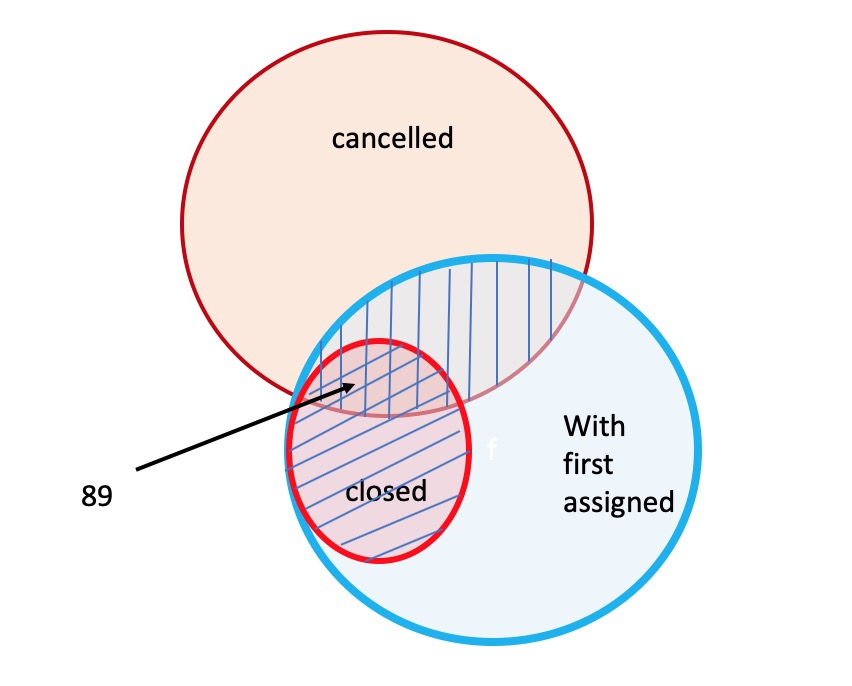

In [62]:
from IPython.display import Image
Image('../input/data.jpg', width = 400)

In [63]:
df_tasks_with_first = df_tasks[df_tasks['task_first_assigned_utc_timestamp'].notna()]

df_tasks_with_first_cancelled = df_tasks_with_first[df_tasks_with_first['cancelled_utc_timestamp'].notna()]

df_tasks_with_first_closed = df_tasks_with_first[df_tasks_with_first['task_closed_utc_timestamp'].notna()]

In [64]:
# task with first, cancelled and closed.
df_tasks_with_fcc = df_tasks_with_first_cancelled.append(df_tasks_with_first_closed, ignore_index = True)
df_tasks_with_fcc.shape

(211248, 29)

In [65]:
df_tasks_with_fcc = df_tasks_with_fcc.drop_duplicates()
df_tasks_with_fcc.shape

(211159, 29)

In [66]:
df_tasks_with_fcc.columns

Index(['cancelled_utc_timestamp', 'poster_id', 'submarket_name',
       'task_category', 'task_closed_utc_timestamp',
       'task_first_assigned_utc_timestamp', 'task_id',
       'task_posted_price_local', 'task_posted_utc_timestamp', 'text_vec_0',
       'text_vec_1', 'text_vec_2', 'text_vec_3', 'text_vec_4', 'text_vec_5',
       'text_vec_6', 'text_vec_7', 'text_vec_8', 'text_vec_9', 'text_vec_10',
       'text_vec_11', 'text_vec_12', 'text_vec_13', 'text_vec_14',
       'text_vec_15', 'text_vec_16', 'text_vec_17', 'text_vec_18',
       'text_vec_19'],
      dtype='object')

# 4 Merge Datasets

<br>
In this part, we merge all 5 datasets together. 

## 4.1 Merge Datasets: Tasks, Offers and Taskers

In [67]:
df_tasks_task_ids = df_tasks_with_fcc['task_id']
len(df_tasks_task_ids)

211159

In [68]:
df_offers_selected = df_offers.loc[df_offers['task_id'].isin(df_tasks_task_ids)]
df_offers_selected.reset_index(drop=True, inplace = True) # drop=True to avoid put old index as a column
df_offers_selected.head(5)

,is_assigned,offer_created_utc_timestamp,offer_id,offer_price,tasker_id,task_id,offer_text_0,offer_text_1,offer_text_2,offer_text_3,...,offer_text_10,offer_text_11,offer_text_12,offer_text_13,offer_text_14,offer_text_15,offer_text_16,offer_text_17,offer_text_18,offer_text_19
0,False,2019-05,12505658,40.38,9274fd8f97,openmarket:4695708,-9.190240,-6.802488,7.407354,9.190240,...,-5.944327,5.944327,-6.056989,-9.190240,-7.447743,-9.190240,9.190240,-4.595120,-5.388058,-9.190240
1,False,2019-05,12472310,153.51,1eaf530311,openmarket:4686699,9.190240,9.190240,-6.194529,-7.364526,...,-6.538344,-5.273306,3.245913,9.190240,-8.042354,-7.236244,7.133284,-0.000000,9.190240,-1.685946
2,False,2019-05,12550337,82.69,b5ee9ebe05,openmarket:4701486,-9.190240,-6.941323,-4.134854,-5.273306,...,-9.190240,-6.020945,9.190240,5.944327,5.667241,9.190240,-9.190240,7.191157,-9.190240,5.273306
3,True,2019-09,14782338,198.82,70cd9983c1,openmarket:5316563,-8.098513,3.838926,-7.318991,9.190240,...,7.218520,-9.190240,-9.190240,-6.416815,9.190240,6.706455,9.190240,-9.190240,-5.944327,9.190240
4,False,2019-05,12352597,77.43,281f7b461f,openmarket:4658469,-5.944327,6.635774,-7.485956,8.255515,...,-6.755845,-5.553152,5.332396,9.190240,9.190240,6.867884,-5.759309,9.190240,8.124395,-7.244939


In [69]:
df_offers_selected.shape

(976761, 26)

In [70]:
df_offers_selected_assigned = df_offers_selected[df_offers_selected['is_assigned'] == True]
print(df_offers_selected_assigned.shape)
print(df_tasks_with_fcc.shape)

(211059, 26)
(211159, 29)


> because len(df_offers_base_assigned) < len(df), it means there are 100 tasks without assigned offers but either cancelled or closed.  

In [71]:
df_tasks_offers = df_tasks_with_fcc.merge(df_offers_selected_assigned, left_on='task_id', right_on='task_id')
df_tasks_offers.shape

(211059, 54)

In [72]:
df_tasks_offers_taskers = df_tasks_offers.merge(df_taskers, left_on='tasker_id', right_on='tasker_id')
df_tasks_offers_taskers.shape

(211059, 64)

## 4.2 Merge Comments

In [73]:
# change comment_id to 1
print('Before: {}'.format(df_comments.shape))
df_comments_tem = df_comments
df_comments_tem['comment_id'] = [0 if x is np.nan else 1 for x in df_comments_tem['comment_id']]
print('After: {}'.format(df_comments_tem.shape))

Before: (5360578, 4)
After: (5360578, 4)


In [74]:
# calculate how many comments to the same author for the same task
print('Before: {}'.format(df_comments_tem.shape))

df_comments_tem = df_comments_tem.groupby(['author_id', 'task_id']).sum()
df_comments_tem.reset_index(inplace=True)

print('After: {}'.format(df_comments_tem.shape))

Before: (5360578, 4)
After: (2896601, 3)


In [75]:
df_comments_tem.head(5)

,author_id,task_id,comment_id
0,00012eb349,openmarket:4795852,1
1,00012eb349,openmarket:4807217,1
2,00012eb349,openmarket:4811120,1
3,00012eb349,openmarket:4820362,1
4,00012eb349,openmarket:4823269,1


In [76]:
print(max(df_comments_tem['comment_id']))
print(min(df_comments_tem['comment_id']))

110
1


In [77]:
# # because datasets have same column names, rename them then merge datasets.  
# rename_columns = {'task_id': 'comments_task_id', 
#                   'comment_id': 'comment_count'}

# df_comments_tem = df_comments_tem.rename(columns = rename_columns)
# df_totc = df_tasks_offers_taskers.merge(df_comments_tem, 
#                                         left_on=['tasker_id'], 
#                                         right_on=['author_id'],
#                                         how='left')

# df_totc.shape

In [78]:
# # drop not useful columns.
# columns = {'author_id'}
# df_totc.drop(columns, axis=1, inplace=True)
# df_totc.shape

In [79]:
# t

In [80]:
# # drop rows that 'task_id' == 'comments_task_id'
# indexNames = df_totc[df_totc['task_id'] == df['comments_task_id']].index
# df_totc.drop(indexNames, inplace = True)

## 4.3 Merge Reviews

In [81]:
df_reviews['review_id'].isna().sum()

0

In [82]:
# change review id to 1
df_reviews_tem = df_reviews
df_reviews_tem['review_id'] = [0 if x is np.nan else 1 for x in df_reviews_tem['review_id']]

In [83]:
# calculate how many reviews to an author for the same task. 
df_reviews_tem = df_reviews_tem.groupby(['author_id', 'task_id']).sum()
df_reviews_tem.reset_index(inplace=True)
df_reviews_tem.shape

(311507, 4)

In [84]:
df_reviews_tem['rating'] = df_reviews_tem['rating'] / df_reviews_tem['review_id']

In [85]:
print(max(df_reviews_tem['rating']))
print(min(df_reviews_tem['rating']))

5.0
1.0


In [86]:
# # because datasets have same column names, rename them then merge datasets. 
# rename_columns = {'task_id': 'reviews_task_id', 
#                   'review_id': 'review_count'}

# df_reviews_tem = df_reviews_tem.rename(columns = rename_columns)

# df_totcr = df_totc.merge(df_reviews_tem, 
#                         left_on=['task_id', 'tasker_id'], 
#                         right_on=['reviews_task_id', 'author_id'],
#                         how='left') # keep the left key
# df_totcr.shape

In [87]:
# # drop not useful columns.
# columns = {'author_id', 'reviews_task_id'}
# df_totcr.drop(columns, axis=1, inplace=True)
# df_totcr.shape

# 5 Add Target Variable

We want to know how many tasks have 'cancelled' in comparison to other tasks. 

And we make 'cancelled' as our __target variable__ we want to predict. 

__0: not cancelled.__

__1: cancelled.__

In [89]:
df_totcr = df_tasks_offers_taskers.copy(deep=True)

In [90]:
# 0: not cancelled; 
# 1: cancelled; 
target_series = [0 if i is np.nan else 1 for i in df_totcr['cancelled_utc_timestamp']]

# totcr means tasker, offer, task, comment and review. 
df_totcr['TARGET'] = target_series
df_totcr['TARGET'].value_counts()

0    172071
1     38988
Name: TARGET, dtype: int64

> df_totcr is our working dataset. 
>
> We can see this case is an imbalanced class problem. We will deal with the imbalance in the Modelling part. 

# 6 Exploratory Data Analysis

<br>
In this part, we will analyse data and apply anomaly detection. 

## 6.1 Column types

Text(0, 0.5, 'Data type')

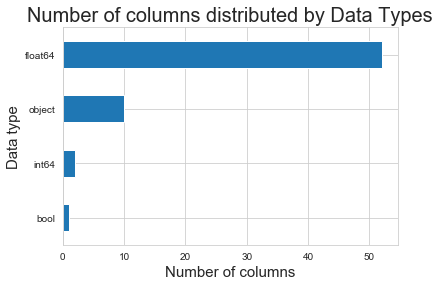

In [91]:
# number of columns for each type
df_totcr.dtypes.value_counts().sort_values().plot(kind = 'barh')
plt.title('Number of columns distributed by Data Types', fontsize = 20)
plt.xlabel('Number of columns', fontsize = 15)
plt.ylabel('Data type', fontsize = 15)

> We need to deal with object variables, because they will bring problems in modelling. 

In [92]:
# Check how many categorical data do the columns having 'object' data types contain. 
df_totcr.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

cancelled_utc_timestamp                  17
poster_id                            139966
submarket_name                           16
task_category                           127
task_closed_utc_timestamp                11
task_first_assigned_utc_timestamp        10
task_id                              211059
task_posted_utc_timestamp                 6
offer_created_utc_timestamp               9
tasker_id                             23001
dtype: int64

## 6.2 Task post time

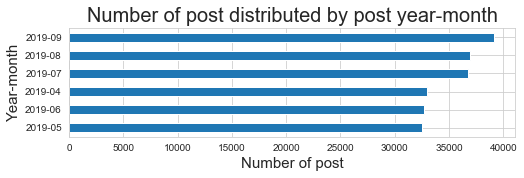

In [93]:
# task post time pic 
df_totcr['task_posted_utc_timestamp'].value_counts().sort_values().plot(kind = 'barh', 
                                                                        figsize = (8, 2))
plt.title('Number of post distributed by post year-month',fontsize=20)
plt.xlabel('Number of post',fontsize=15)
plt.ylabel('Year-month',fontsize=15);

## 6.3 Task first assigned time

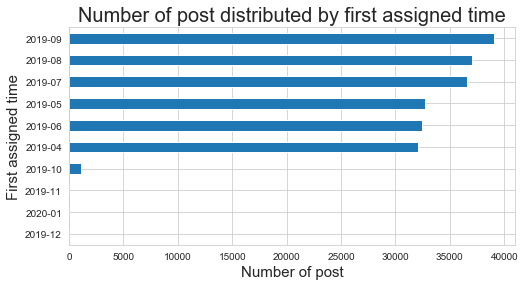

In [94]:
# task first assigned time pic 
df_totcr['task_first_assigned_utc_timestamp'].value_counts() \
                                             .sort_values() \
                                             .plot(kind = 'barh', 
                                                   figsize = (8, 4))
plt.title('Number of post distributed by first assigned time',fontsize=20)
plt.xlabel('Number of post',fontsize=15)
plt.ylabel('First assigned time',fontsize=15);

> Notice that the 2019-01, 2019-02, 2019-03 are missing and number of first assigned between 2019-11 to 2020-01 are low. 
>
> I guess it is because the new year and Christmas festivals. 

## 6.4 Offer created time

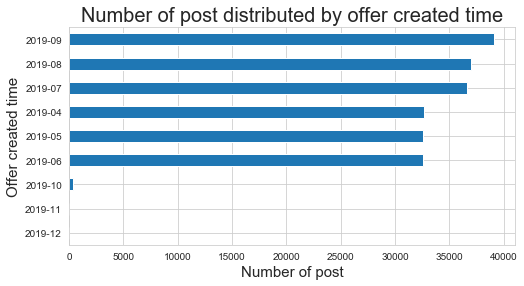

In [95]:
# offer created time pic 
df_totcr['offer_created_utc_timestamp'].value_counts() \
                                             .sort_values() \
                                             .plot(kind = 'barh', 
                                                   figsize = (8, 4))
plt.title('Number of post distributed by offer created time',fontsize=20)
plt.xlabel('Number of post',fontsize=15)
plt.ylabel('Offer created time',fontsize=15);

> This figer aligns with the 'First assigned time', less jobs post during the festival period. 

## 6.5 Task category

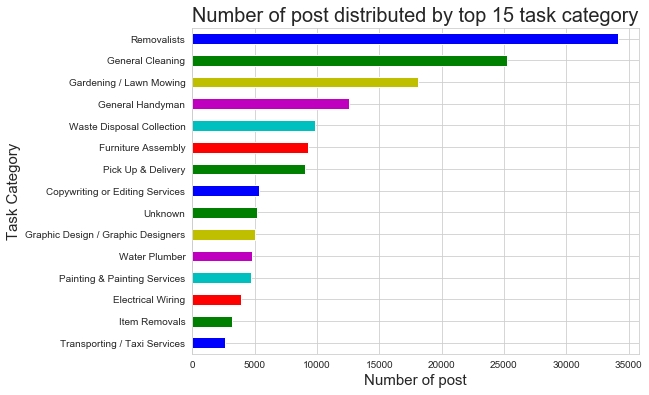

In [96]:
# task_category
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'g']
n = 15
df_totcr['task_category'].value_counts().sort_values().tail(n).plot(kind = 'barh', 
                                                                    figsize = (8, 6),
                                                                    color = colors)
plt.title('Number of post distributed by top {} task category'.format(n), fontsize=20)
plt.xlabel('Number of post', fontsize=15)
plt.ylabel('Task Category', fontsize=15);

## 6.6 Submarket name

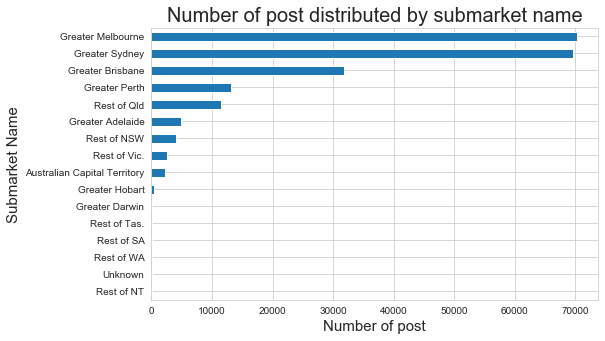

In [97]:
# submarket_name
df_totcr['submarket_name'].value_counts().sort_values().plot(kind = 'barh', 
                                                             figsize = (8, 5))
plt.title('Number of post distributed by submarket name',fontsize=20)
plt.xlabel('Number of post',fontsize=15)
plt.ylabel('Submarket Name',fontsize=15);

## 6.7 Offer price

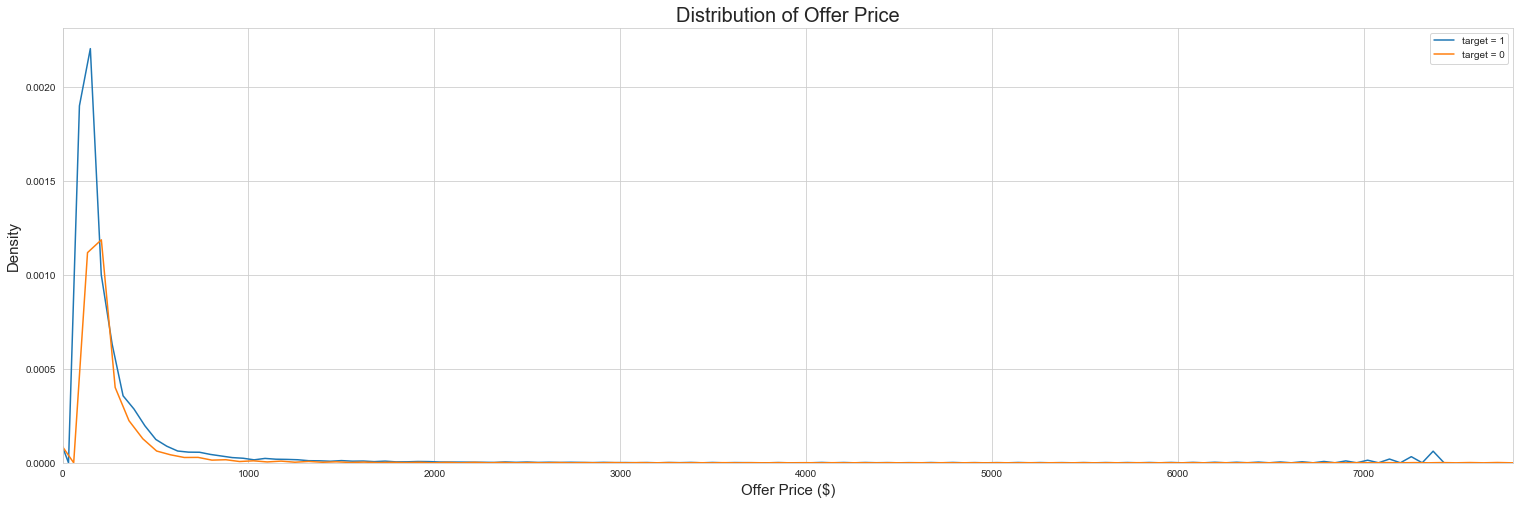

In [98]:
# kernel density estimate
fig = plt.figure(figsize=(26,8))
sns.kdeplot(df_totcr.loc[df_totcr['TARGET'] == 1, 'offer_price'], label = 'target = 1').set(xlim=(0))
sns.kdeplot(df_totcr.loc[df_totcr['TARGET'] == 0, 'offer_price'], label = 'target = 0').set(xlim=(0))
plt.xlabel('Offer Price ($)',fontsize=15)
plt.ylabel('Density',fontsize=15)
plt.title('Distribution of Offer Price',fontsize=20);

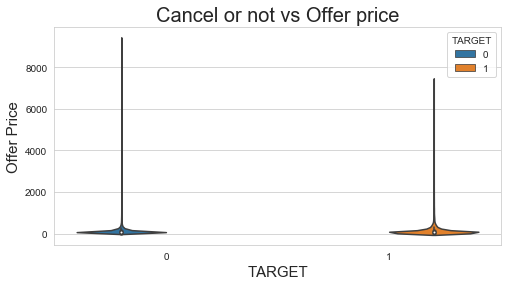

In [99]:
fig = plt.figure(figsize=(8,4))
sns.violinplot(x='TARGET',y='offer_price',data=df_totcr, hue='TARGET')
plt.title('Cancel or not vs Offer price', fontsize=20)
plt.xlabel('TARGET', fontsize=15)
plt.ylabel('Offer Price', fontsize=15);

Max offer price: 9413.16
Min offer price: 2.97


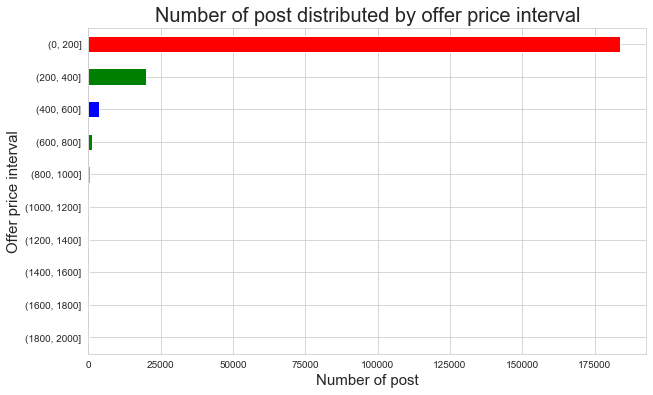

In [100]:
# offer price interval 

offer_price = pd.cut(df_totcr['offer_price'], range(0, 9700, 200), right=True)
print('Max offer price: {}'.format(max(df_totcr['offer_price'])))
print('Min offer price: {}'.format(min(df_totcr['offer_price'])))

offer_price_sorted = offer_price.value_counts().sort_values()

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'g']
offer_price_sorted.tail(10).plot(kind = 'barh', 
                                 figsize = (10, 6),
                                 color = colors)

plt.title('Number of post distributed by offer price interval', fontsize=20)
plt.xlabel('Number of post',fontsize=15)
plt.ylabel('Offer price interval',fontsize=15);

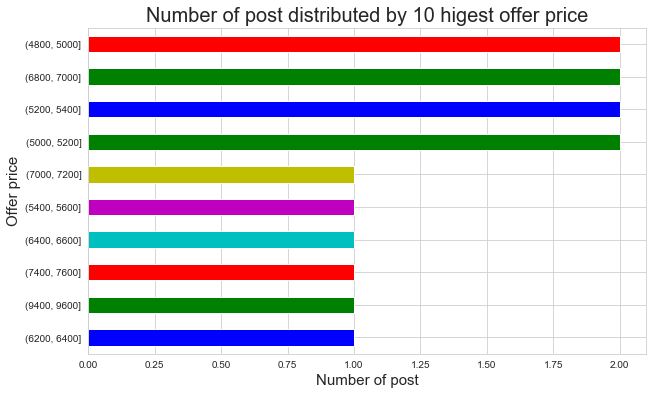

In [101]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'g']
offer_price_sorted[offer_price_sorted > 0].head(10).plot(kind = 'barh', 
                                                         figsize = (10, 6),
                                                         color = colors)
plt.title('Number of post distributed by 10 higest offer price',fontsize=20)
plt.xlabel('Number of post', fontsize=15)
plt.ylabel('Offer price', fontsize=15);

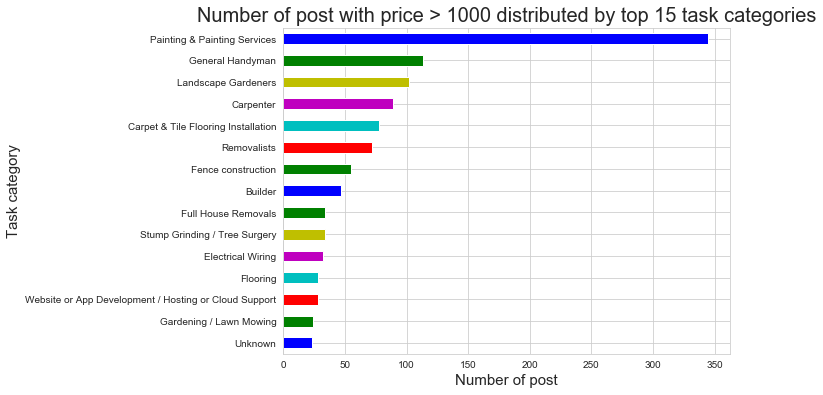

In [102]:
# offer price vs task_category

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'g']
price = 1000 # offer price
n = 15

df_totcr[df_totcr['offer_price'] > price]['task_category'].value_counts() \
                                                          .sort_values() \
                                                          .tail(n) \
                                                          .plot(kind = 'barh', 
                                                                figsize = (8, 6),
                                                                color = colors)
plt.title('Number of post with price > {} distributed by top {} task categories'.format(price, n), fontsize=20)
plt.xlabel('Number of post', fontsize=15)
plt.ylabel('Task category', fontsize=15);

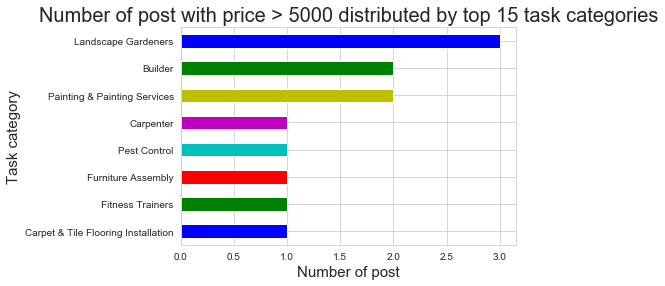

In [103]:
# offer price vs task_category

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'g']
price = 5000 # offer price
n = 15

df_totcr[df_totcr['offer_price'] > price]['task_category'].value_counts() \
                                                          .sort_values() \
                                                          .tail(n) \
                                                          .plot(kind = 'barh', 
                                                                figsize = (6, 4),
                                                                color = colors)
plt.title('Number of post with price > {} distributed by top {} task categories'.format(price, n), fontsize=20)
plt.xlabel('Number of post', fontsize=15)
plt.ylabel('Task category', fontsize=15);

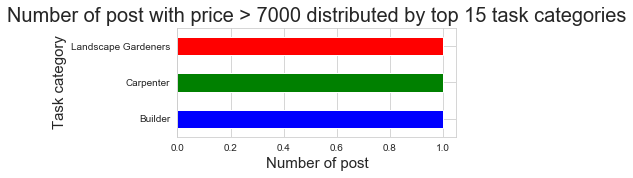

In [104]:
# offer price vs task_category

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'g']
price = 7000 # offer price
n = 15

df_totcr[df_totcr['offer_price'] > price]['task_category'].value_counts() \
                                                          .sort_values() \
                                                          .tail(n) \
                                                          .plot(kind = 'barh', 
                                                                figsize = (5, 2),
                                                                color = colors)
plt.title('Number of post with price > {} distributed by top {} task categories'.format(price, n), fontsize=20)
plt.xlabel('Number of post', fontsize=15)
plt.ylabel('Task category', fontsize=15);

## 6.8 Reviews

In [105]:
# On average, how many reviews for each tasker
df_taskers_reviews = df_totcr[['tasker_id', 'review_count']]
df_tem = df_taskers_reviews.groupby(['tasker_id']).mean()
df_tem.reset_index(inplace=True)
df_tem['review_count'].mean()

KeyError: "['review_count'] not in index"

## 6.9 Comments

In [ ]:
# On average, how many comments for each tasker
df_taskers_reviews = df_totcr[['tasker_id', 'comment_count']]
df_tem = df_taskers_reviews.groupby(['tasker_id']).mean()
df_tem.reset_index(inplace=True)
df_tem['comment_count'].mean()

## 6.10 Target

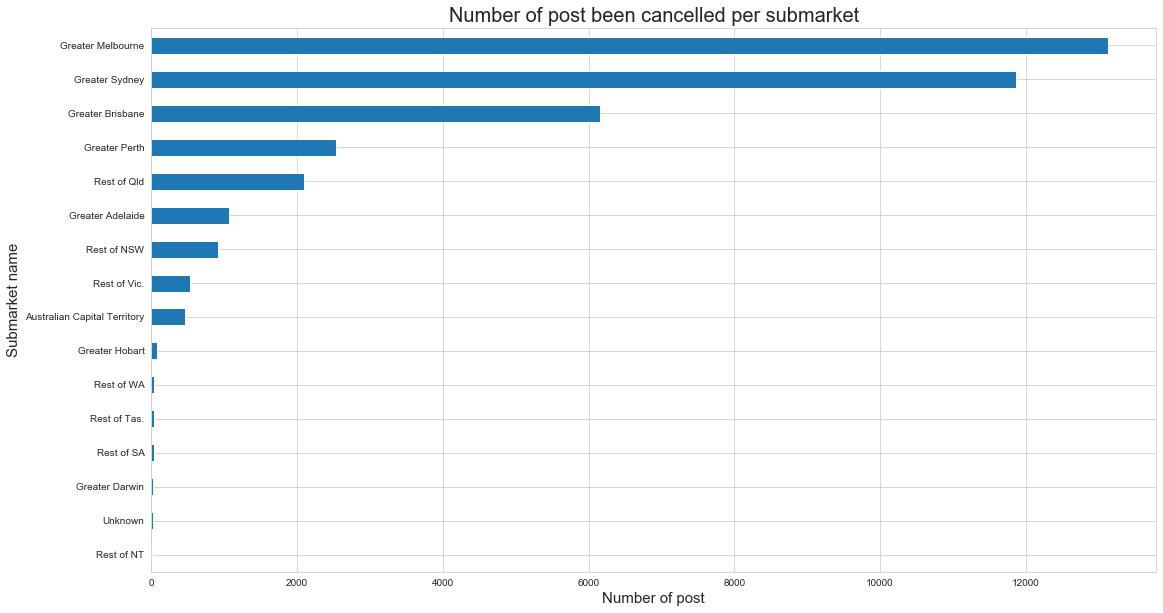

In [106]:
fig = plt.figure(figsize=(18,10))
df_totcr[df_totcr['TARGET']==1].groupby('submarket_name')['TARGET'].count().sort_values().plot(kind='barh')
plt.ylabel('Submarket name',fontsize=15)
plt.xlabel('Number of post',fontsize=15)
plt.title('Number of post been cancelled per submarket',fontsize=20);

In [ ]:
fig = plt.figure(figsize=(18,10))
df_totcr[df_totcr['TARGET']==0].groupby('submarket_name')['TARGET'].count().sort_values().plot(kind='barh')
plt.ylabel('Submarket name',fontsize=15)
plt.xlabel('Number of post',fontsize=15)
plt.title('Number of post NOT been cancelled per submarket',fontsize=20);

In [ ]:
fig = plt.figure(figsize=(18,12))
df_totcr[df_totcr['TARGET']==1].groupby('task_category')['TARGET'].count().sort_values().tail(30).plot(kind='barh')
plt.ylabel('Task category',fontsize=15)
plt.xlabel('Number of post',fontsize=15)
plt.title('Number of post been cancelled per task category (top 30)',fontsize=20);

# 7 Clean Data

In [107]:
# Check how many categorical data do the columns having 'object' data types contain. 
df_totcr.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

cancelled_utc_timestamp                  17
poster_id                            139966
submarket_name                           16
task_category                           127
task_closed_utc_timestamp                11
task_first_assigned_utc_timestamp        10
task_id                              211059
task_posted_utc_timestamp                 6
offer_created_utc_timestamp               9
tasker_id                             23001
dtype: int64

In [ ]:
df_totcr.columns

In [ ]:
df_totcr.shape

## 7.1 Drop Columns

We can drop columns:

1. 'cancelled_utc_timestamp' because we have generated 'TARGET' from it already.
2. 'task_posted_utc_timestamp' because they distributed equally. 
3. 'is_assigned' because all data item's 'is_assigned' are True. 
4. 'poster_id', 
5. 'task_id', 
6. 'offer_id', 
7. 'tasker_id', because it will not affect detection.

In [108]:
# drop columns. 
columns = ['cancelled_utc_timestamp', 
           'task_posted_utc_timestamp',
           'is_assigned', 
           'poster_id', 
           'task_id',
           'offer_id',
           'tasker_id'] 
df_totcr.drop(columns, axis=1, inplace=True)
df_totcr.shape

(211059, 58)

> We have 61 columns remaining. Let's further check their information. 

## 7.2 Convert time from string to int
By doing this, we can reduce the object columns. 

In [109]:
df_totcr.columns

Index(['submarket_name', 'task_category', 'task_closed_utc_timestamp',
       'task_first_assigned_utc_timestamp', 'task_posted_price_local',
       'text_vec_0', 'text_vec_1', 'text_vec_2', 'text_vec_3', 'text_vec_4',
       'text_vec_5', 'text_vec_6', 'text_vec_7', 'text_vec_8', 'text_vec_9',
       'text_vec_10', 'text_vec_11', 'text_vec_12', 'text_vec_13',
       'text_vec_14', 'text_vec_15', 'text_vec_16', 'text_vec_17',
       'text_vec_18', 'text_vec_19', 'offer_created_utc_timestamp',
       'offer_price', 'offer_text_0', 'offer_text_1', 'offer_text_2',
       'offer_text_3', 'offer_text_4', 'offer_text_5', 'offer_text_6',
       'offer_text_7', 'offer_text_8', 'offer_text_9', 'offer_text_10',
       'offer_text_11', 'offer_text_12', 'offer_text_13', 'offer_text_14',
       'offer_text_15', 'offer_text_16', 'offer_text_17', 'offer_text_18',
       'offer_text_19', 'profile_vec_0', 'profile_vec_1', 'profile_vec_2',
       'profile_vec_3', 'profile_vec_4', 'profile_vec_5', 'profi

In [110]:
# Check how many categorical data do the columns having 'object' data types contain. 
df_totcr.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

submarket_name                        16
task_category                        127
task_closed_utc_timestamp             11
task_first_assigned_utc_timestamp     10
offer_created_utc_timestamp            9
dtype: int64

In [111]:
for x in df_totcr:
    if df_totcr[x].isnull().any():
        print(x)

task_closed_utc_timestamp


In [112]:
df_totcr['offer_created_utc_timestamp'] = [int(x[5:7]) for x in df_totcr['offer_created_utc_timestamp']]
df_totcr['offer_created_utc_timestamp'].drop_duplicates()

0          5
2          9
5          4
16         6
18         8
23         7
1028      10
131267    12
148327    11
Name: offer_created_utc_timestamp, dtype: int64

In [113]:
df_totcr['task_first_assigned_utc_timestamp'] = [int(x[5:7]) for x in df_totcr['task_first_assigned_utc_timestamp']]
df_totcr['task_first_assigned_utc_timestamp'].drop_duplicates()

0          5
2          9
5          4
16         6
18         8
23         7
490       10
103714    11
121983     1
131267    12
Name: task_first_assigned_utc_timestamp, dtype: int64

In [114]:
df_totcr['task_closed_utc_timestamp'] = \
                       [0 if x is np.nan else int(x[5:7]) for x in df_totcr['task_closed_utc_timestamp']]

df_totcr['task_closed_utc_timestamp'].drop_duplicates()

0          0
7          4
9          9
10         5
20         8
23         7
27         6
160       10
8862      11
11280     12
146445     1
207424     2
Name: task_closed_utc_timestamp, dtype: int64

In [115]:
df_totcr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 211059 entries, 0 to 211058
Data columns (total 58 columns):
submarket_name                       211059 non-null object
task_category                        211059 non-null object
task_closed_utc_timestamp            211059 non-null int64
task_first_assigned_utc_timestamp    211059 non-null int64
task_posted_price_local              211059 non-null float64
text_vec_0                           211059 non-null float64
text_vec_1                           211059 non-null float64
text_vec_2                           211059 non-null float64
text_vec_3                           211059 non-null float64
text_vec_4                           211059 non-null float64
text_vec_5                           211059 non-null float64
text_vec_6                           211059 non-null float64
text_vec_7                           211059 non-null float64
text_vec_8                           211059 non-null float64
text_vec_9                           2110

> The memory usage is 110+ MB. 

## 7.2 PCA: Principle Component Analysis for dimensionality reduction

In [117]:
# Check how many categorical data do the columns having 'object' data types contain. 
df_totcr.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

submarket_name     16
task_category     127
dtype: int64

> For object column with categories = 2, we can do label encoder, since all the object columns categories are > 2, so we use one-hot encoding.  

In [118]:
print('Before getting dummies: {}'.format(df_totcr.shape))
df_totcr = pd.get_dummies(df_totcr)
print('After getting dummies: {}'.format(df_totcr.shape))

Before getting dummies: (211059, 58)
After getting dummies: (211059, 199)


In [119]:
for x in df_totcr:
    if df_totcr[x].isna().any():
        print(x)

In [120]:
df_totcr = df_totcr.fillna(0)
df_totcr.shape

(211059, 199)

# 8 Modelling

In [121]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [122]:
def print_score(clf, X_test, y_test):
    """
    Classification report function.
    """
    print("Test Result:\n")        
    print("accuracy score = {}".format(accuracy_score(y_test, clf.predict(X_test))))
    print("Classification Report = \n{}".format(classification_report(y_test, clf.predict(X_test))))
    print("Confusion Matrix = \n{}".format(confusion_matrix(y_test, clf.predict(X_test))))  

## 8.1 Free up the memory

In [123]:
# Freeing up the memory.
del start_df_taskers
del start_df_reviews
del start_df_offers
del start_df_comments
del start_df_tasks

gc.collect()

20905

## 8.2 Split data

In [124]:
# split dataset into train and test subsets. 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = \
       train_test_split(df_totcr.drop('TARGET',axis=1),df_totcr['TARGET'],test_size=0.15)

In [125]:
# Standardizing features by removing the mean and scaling to unit variance
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
np.isnan(X_train).any()

False

## 8.3 Deal with imbalance

In [126]:
df_totcr['TARGET'].value_counts()

0    172071
1     38988
Name: TARGET, dtype: int64

> The data is imbalance, need to use SMOTE to deal with it. 

In [127]:
# Oversampling only the training set using Synthetic Minority Oversampling Technique (SMOTE)
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=12, ratio = 1.0)
x_train_r, y_train_r = sm.fit_sample(X_train, y_train)

## 8.4 Logistic Regression

In [128]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(C = 0.0001, random_state=21)

log_reg.fit(x_train_r, y_train_r)

LogisticRegression(C=0.0001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=21, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [129]:
# support means the number of 0 and 1
print_score(log_reg, X_test, y_test)

Test Result:

accuracy score = 0.9995262010802616
Classification Report = 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     25663
           1       1.00      1.00      1.00      5996

    accuracy                           1.00     31659
   macro avg       1.00      1.00      1.00     31659
weighted avg       1.00      1.00      1.00     31659

Confusion Matrix = 
[[25661     2]
 [   13  5983]]


## 7.2 Random Forest Tree

In [130]:
from sklearn.ensemble import RandomForestClassifier

In [131]:
clf_rf = RandomForestClassifier(n_estimators=40, random_state=21)
clf_rf.fit(x_train_r, y_train_r)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40,
                       n_jobs=None, oob_score=False, random_state=21, verbose=0,
                       warm_start=False)

In [132]:
print_score(clf_rf, X_test, y_test)

Test Result:

accuracy score = 0.9994946144856123
Classification Report = 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     25663
           1       1.00      1.00      1.00      5996

    accuracy                           1.00     31659
   macro avg       1.00      1.00      1.00     31659
weighted avg       1.00      1.00      1.00     31659

Confusion Matrix = 
[[25661     2]
 [   14  5982]]


# 9 Conclusion

We would also like to know your answers to the following questions:

1. Why did you choose the model that you chose vs other models?
2. What different ideas did you try to build your model?
3. How would you communicate how this model works and its effectiveness to someone who is non-technical?
4. What are the limitations of this model?
5. What extra data points could be tested to improve the results?


__1. Why did you choose the model that you chose vs other models?__

This is a Credit Scoring problem, and we can use logistic regression and random forest tree to model it. 

__2. What different ideas did you try to build your model?__

At beginning, want to use only Taskers, Offers and Tasks dataset to tain the model, but later realise that I better use all these 5 datasets. 

__3. How would you communicate how this model works and its effectiveness to someone who is non-technical?__

Given 5 datasets.
Abstract task cases with result (either closed or cancelled).
Merge all these 5 datasets based on the abstracted task cases into a new dataset.
Select useful features from the new dataset. 
Then train the new dataset and get useful rules. 
Apply the rules on taskers to predict how likely he/she will cancel the task. 

__4. What are the limitations of this model?__

1. comment and review issue 1. 

   Because the training dataset contains reviews and comments, for a new registered tasker who hasn't had any review or comment yet and the lack of review or comment will affect the prediction result. 

   One solution for it is only use taskers, offers and tasks dataset to train the model. 
   
   For the time sake, I am not going to do it here. 
   
2. comment and review issue 2.

   The reason of high accuracy might becuase of introducing the comment and review in training dataset. Because the taskers how cancelled the tasks won't leave comments or reivews, normally is the one who finished the task will do. 
   
3. comment and review issue 3.

   However, if we isolate the comments or reivews from training data, that will lose very useful information for long term taskers especially who has high rating in the review. 
   
So, for comment and review, need further investigation. 

4. primary key 'tasker_id' in dataset tasker is not unique. 

   The primary key 'tasker_id' in dataset tasker is not unique, I don't know why since not enough information provided.
   
   I made them unique, not sure if it will change the taskers table meaning. 
   
5. Cancelled, closed and first-assigned issue. 

   If a task is first-assigned and then been cancelled by tasker A, then assigned to tasker B and cancelled to tasker B, ... then assigned to tasker Z and tasker Z finished it. Then in this case, the task has been cancelled 25 times but no record left on dataset that tasker A ... Y has cancelled once. 
   

__5. What extra data points could be tested to improve the results?__

As we discussed on question 4, point 5, a history dataset of the cancelation would be helpful. 

Additionally, for a tasker, even he/she has a high cancel rate in general, he/she might have very low cancel rate for ceratin task category, this is a case we can do further research. 

__-----------------End------------------__